In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree

In [24]:
df = pd.read_csv("./data/preprocessed/subband_data.csv")
#df = pd.read_csv("./data/preprocessed/data.csv")

df = df.dropna()
data = df.to_numpy()
Y = data[:,-1]
X = data[:,1:-1]

X = X-np.mean(X, axis=0)
X = X/np.std(X, axis=0)

# X = X[:,6:12]

# scaler = MinMaxScaler()
# scaler.fit(X)
# X = scaler.transform(X)

# X[:,0] = np.log10(1000*X[:,0]+0.5)
# X[:,1] = np.log10(1000*X[:,1]+0.5)
# X[:,2] = np.log10(1000*X[:,2]+0.5)
# X[:,3] = np.log10(1000*X[:,3]+0.5)
# X[:,4] = np.log10(1000*X[:,4]+0.5)
# X[:,5] = np.log10(10000*X[:,5]+0.5)

# #X[:,6] = np.log10(1000*X[:,6]+0.5)
# X[:,7] = np.log10(1000*X[:,7]+0.5)
# X[:,8] = np.log10(1000*X[:,8]+0.5)
# X[:,9] = np.log10(1000*X[:,9]+0.5)
# X[:,10] = np.log10(1000*X[:,10]+0.5)
# X[:,11] = np.log10(1000*X[:,11]+0.5)

# X[:,12] = np.log10(1*X[:,12]+0.1)
# X[:,13] = np.log10(100*X[:,13]+0.1)
# X[:,14] = np.log10(1*X[:,14]+0.1)

# X = X[:,0:6]

# scaler = MinMaxScaler()
# scaler.fit(X)
# X = scaler.transform(X)

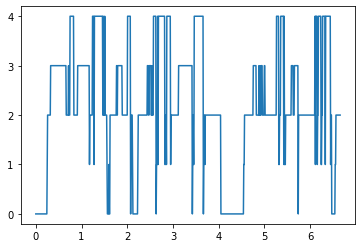

In [19]:
N = 800
dt = np.linspace(0, (N-1)*30/3600, N)
plt.plot(dt, Y[:N])
_ = plt.yticks(np.unique(Y[:N]))

In [20]:
Ntotal = X.shape[0]
Ntrain = int(Ntotal*0.3)
Ntest = Ntotal-Ntrain

idxs = np.arange(Ntotal)
np.random.shuffle(idxs)

Xd, Yd = X[idxs], Y[idxs]

Xtrain = Xd[:Ntrain]
Ytrain = Yd[:Ntrain]
Xtest = Xd[Ntrain:Ntrain+Ntest]
Ytest = Yd[Ntrain:Ntrain+Ntest]

clf = SVC()
clf.fit(Xtrain, Ytrain)

ypred = clf.predict(Xtrain)
train_acc = np.mean(ypred == Ytrain)
ypred = clf.predict(Xtest)
test_acc = np.mean(ypred == Ytest)
print(train_acc)
print(test_acc)

0.7983930414270971
0.7944149608289108


In [27]:
Ntotal = X.shape[0]
Ntrain = int(Ntotal*0.8)
Ntest = Ntotal-Ntrain

idxs = np.arange(Ntotal)
np.random.shuffle(idxs)

Xd, Yd = X[idxs], Y[idxs]

Xtrain = Xd[:Ntrain]
Ytrain = Yd[:Ntrain]
Xtest = Xd[Ntrain:Ntrain+Ntest]
Ytest = Yd[Ntrain:Ntrain+Ntest]

clf = tree.DecisionTreeClassifier(max_depth=20, min_samples_split=30)
#clf = tree.DecisionTreeClassifier()
clf = clf.fit(Xtrain, Ytrain)

ypred = clf.predict(Xtrain)
train_acc = np.mean(ypred == Ytrain)
ypred = clf.predict(Xtest)
test_acc = np.mean(ypred == Ytest)

print(train_acc)
print(test_acc)

0.8947397517759903
0.7782200110558319


In [22]:
Ntotal = X.shape[0]
Ntrain = int(Ntotal*0.8)
Ntest = Ntotal-Ntrain

idxs = np.arange(Ntotal)
np.random.shuffle(idxs)

Xd, Yd = X[idxs], Y[idxs]

Xtrain = Xd[:Ntrain]
Ytrain = Yd[:Ntrain]
Xtest = Xd[Ntrain:Ntrain+Ntest]
Ytest = Yd[Ntrain:Ntrain+Ntest]

clf = LogisticRegression(max_iter=1000)
#clf = tree.DecisionTreeClassifier()
clf = clf.fit(Xtrain, Ytrain)

ypred = clf.predict(Xtrain)
train_acc = np.mean(ypred == Ytrain)
ypred = clf.predict(Xtest)
test_acc = np.mean(ypred == Ytest)

print(train_acc)
print(test_acc)

0.7841446222738204
0.7897180762852405


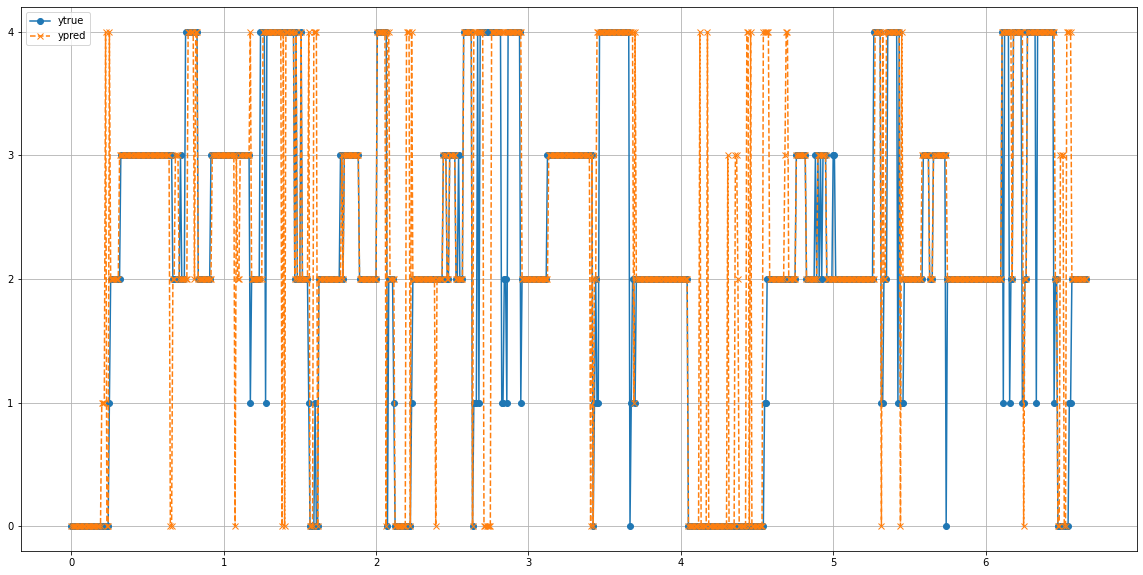

In [23]:
N = 800
dt = np.linspace(0, (N-1)*30/3600, N)

fig = plt.figure(figsize=(20,10))
plt.plot(dt, Y[:N], marker="o", label="ytrue")
plt.plot(dt, clf.predict(X[:N]), linestyle="--", marker="x", label="ypred")
_ = plt.yticks(np.unique(Y[:N]))
plt.grid(True)
plt.legend()